In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = "/home/jobsr/Documents/GitHub/iesb_deeplearning/rnn/timeseries/data/CITIMON.csv"

try:
    # Carregar o CSV
    df = pd.read_csv(file_path, parse_dates=True, index_col=0)
    print("CSV carregado")
    print(f"Colunas disponíveis: {df.columns.tolist()}")
    print(df.head())

except FileNotFoundError:
    print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
    exit()

CSV carregado
Colunas disponíveis: ['CCIUAC', 'CCIUTC', 'CONB', 'CONQ', 'EEC', 'EEGP', 'EXVUS', 'FM1', 'FM1D82', 'FSPCAP', 'FSPCOM', 'FSPCON', 'IP', 'LHUR', 'LUINC', 'PW', 'RCARD', 'RTRR']
             CCIUAC    CCIUTC     CONB     CONQ    EEC   EEGP  EXVUS  \
DATE                                                                   
1980-01-01  67166.0  153636.0  48579.0  66820.0  7.403  111.0  85.52   
1980-02-01  67119.0  153308.0  47759.0  64049.0  6.962  118.6  86.37   
1980-03-01  66786.0  152347.0  46705.0  64831.0  6.848  123.0  90.26   
1980-04-01  65837.0  150937.0  45835.0  63913.0  5.986  124.2  91.09   
1980-05-01  65035.0  149238.0  46819.0  64598.0  5.837  124.4  86.96   

                   FM1      FM1D82  FSPCAP  FSPCOM  FSPCON    IP  LHUR  LUINC  \
DATE                                                                            
1980-01-01  386.099999  477.799999  126.68  110.87   85.09  85.9   6.3  416.0   
1980-02-01  389.799999  476.500000  131.27  115.34   83.14  86.

/tmp/ipykernel_17436/1790799939.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=True, index_col=0)


In [3]:
# Definir a coluna de interesse
column_of_interest = 'CONB'


# Usar 'DATE' como coluna de tempo e 'column_of_interest' como coluna de interesse
if df.shape[1] > 0:
    if column_of_interest in df.columns:
        series_name = column_of_interest
    else:
        print(f"Erro: A coluna de interesse '{column_of_interest}' não foi encontrada no CSV.")
        exit()
    # A coluna de tempo já foi usada como index ao ler o CSV (index_col=0), que é 'DATE'
else:
    print("Erro: O DataFrame está vazio ou não tem colunas.")
    exit()

print(f"\nUsando a coluna '{series_name}' como série temporal principal.")
main_series = df[series_name].values.astype(float)


Usando a coluna 'CONB' como série temporal principal.


In [4]:
# Verificar se a série contém valores NaN
if np.isnan(main_series).any():
    print("Detectados valores NaN. Realizando interpolação linear.")
    main_series = pd.Series(main_series).interpolate(method='linear').values

Detectados valores NaN. Realizando interpolação linear.


In [5]:
# Normalização dos dados: importante para RNNs
scaler = MinMaxScaler(feature_range=(-1, 1)) # -1 e 1 é comum para tanh
main_series_scaled = scaler.fit_transform(main_series.reshape(-1, 1)) # Reshape para (n_samples, n_features)

In [6]:
# 2. Preparação dos Dados para Treinamento (dados normalizados)
def create_dataset(series, input_sequence_length):
    X, y = [], []
    for i in range(len(series) - input_sequence_length):
        X.append(series[i : i + input_sequence_length])
        y.append(series[i + input_sequence_length])
    return np.array(X), np.array(y)

input_sequence_length = 30 # Comprimento da sequência
X_np, y_np = create_dataset(main_series_scaled.flatten(), input_sequence_length)

# Convertendo para tensores PyTorch
X_tensor = torch.from_numpy(X_np).float().unsqueeze(2)
y_tensor = torch.from_numpy(y_np).float().unsqueeze(1)

print(f"Formato de X_tensor: {X_tensor.shape}")
print(f"Formato de y_tensor: {y_tensor.shape}")

Formato de X_tensor: torch.Size([115, 30, 1])
Formato de y_tensor: torch.Size([115, 1])


In [7]:
# Dividir em treino e teste (mantendo 80/20)
train_size = int(len(X_tensor) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

In [8]:
# 3. Definição da Arquitetura da RNN
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [10]:
# Parâmetros da RNN
input_size = 1
hidden_size = 64 
output_size = 1
num_layers = 2

# Instanciando o modelo
model = SimpleRNN(input_size, hidden_size, output_size, num_layers)

# Definindo a função de perda e o otimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # learning rate

In [11]:
# 4. Treinamento do Modelo
num_epochs = 300 # número de épocas
for epoch in range(num_epochs):
    model.train() # Coloca o modelo em modo de treinamento
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    
    # Clipagem de gradiente: Ajuda a evitar o problema de gradiente explosivo em RNNs
    # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

print("Treinamento concluído!")

Epoch [20/300], Loss: 0.017612
Epoch [40/300], Loss: 0.008898
Epoch [60/300], Loss: 0.007544
Epoch [80/300], Loss: 0.007248
Epoch [100/300], Loss: 0.007109
Epoch [120/300], Loss: 0.007062
Epoch [140/300], Loss: 0.007001
Epoch [160/300], Loss: 0.006907
Epoch [180/300], Loss: 0.006734
Epoch [200/300], Loss: 0.006978
Epoch [220/300], Loss: 0.006004
Epoch [240/300], Loss: 0.005869
Epoch [260/300], Loss: 0.007820
Epoch [280/300], Loss: 0.006780
Epoch [300/300], Loss: 0.006504
Treinamento concluído!


In [12]:
# 5. Avaliação e Previsão
model.eval()
with torch.no_grad():
    train_predict_scaled = model(X_train).numpy()
    test_predict_scaled = model(X_test).numpy()

# Inverter a normalização para plotar os resultados na escala original
train_predict = scaler.inverse_transform(train_predict_scaled)
y_train_original = scaler.inverse_transform(y_train.numpy())

test_predict = scaler.inverse_transform(test_predict_scaled)
y_test_original = scaler.inverse_transform(y_test.numpy())

# Plotagem dos resultados
# Precisamos alinhar as previsões com os dados originais no tempo
full_series_original = scaler.inverse_transform(main_series_scaled).flatten()

train_plot = np.empty_like(full_series_original)
train_plot[:] = np.nan
train_plot[input_sequence_length : len(train_predict) + input_sequence_length] = train_predict.flatten()

test_plot = np.empty_like(full_series_original)
test_plot[:] = np.nan
test_plot[len(train_predict) + input_sequence_length : len(train_predict) + input_sequence_length + len(test_predict)] = test_predict.flatten()

Shape de train_predict: (92, 1)
Shape de test_predict: (23, 1)
Shape de y_train_original: (92, 1)
Shape de y_test_original: (23, 1)
Shape de full_series_original: (145,)


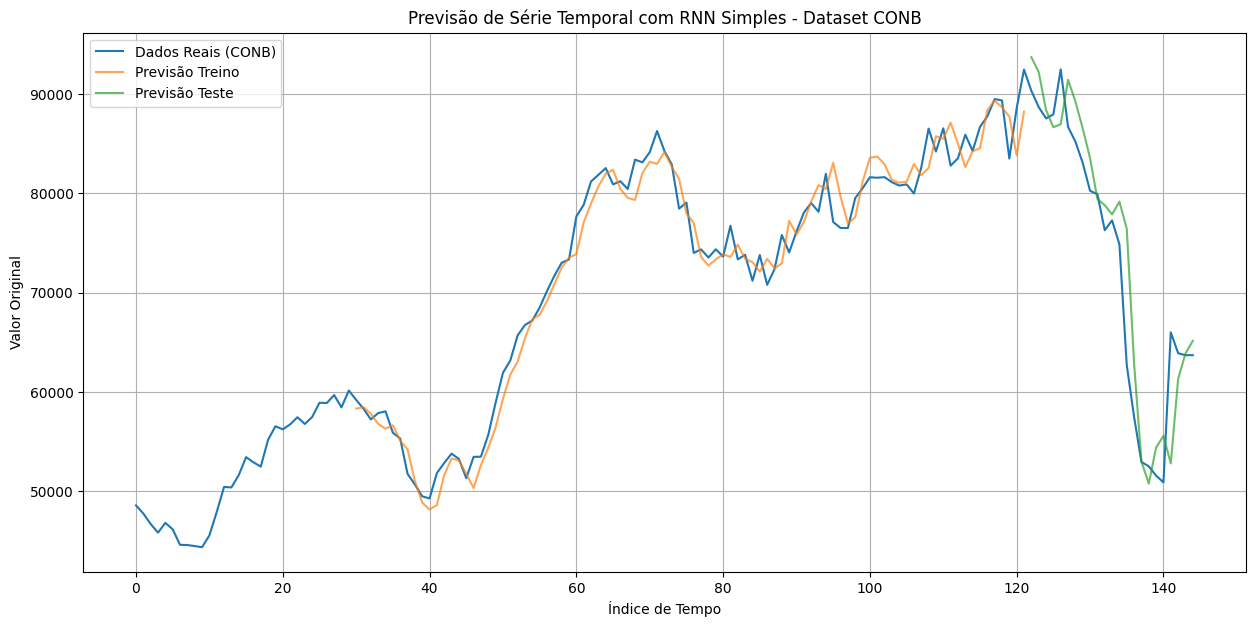

In [13]:
# EXIBIÇÃO DOS RESULTADOS DAS MÉTRICAS
print(f"Shape de train_predict: {train_predict.shape}")
print(f"Shape de test_predict: {test_predict.shape}")
print(f"Shape de y_train_original: {y_train_original.shape}")
print(f"Shape de y_test_original: {y_test_original.shape}")
print(f"Shape de full_series_original: {full_series_original.shape}")

# Plotando os resultados
plt.figure(figsize=(15, 7))
plt.plot(full_series_original, label=f'Dados Reais ({series_name})')
plt.plot(train_plot, label='Previsão Treino', alpha=0.7)
plt.plot(test_plot, label='Previsão Teste', alpha=0.7)
plt.title(f"Previsão de Série Temporal com RNN Simples - Dataset {series_name}")
plt.xlabel("Índice de Tempo")
plt.ylabel("Valor Original")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
from sklearn.metrics import r2_score

r2_train = r2_score(y_train_original, train_predict)
r2_test = r2_score(y_test_original, test_predict)

print(f"\nR² no conjunto de Treino: {r2_train:.4f}")
print(f"R² no conjunto de Teste: {r2_test:.4f}")


R² no conjunto de Treino: 0.9690
R² no conjunto de Teste: 0.8674
